In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import os

## Voyager Telemetry Demodulation

In [2]:
def string_to_binary(string):
    return ''.join(format(x, '08b') for x in bytearray(string, 'utf-8'))

In [3]:
def binary_to_string(binary):
    ba = []
    for i in range(len(binary)//8):
        ba.append(int(binary[i*8:(i+1)*8], base=2))
    return ascii(''.join([ chr(c) for c in ba]))[1:-1]

In [4]:
def decode_msg(t, f, freq_carrier, samples_per_period, plot=False):
    """
    Decodes the message
    
    DO NOT CHANGE THIS FUNCTION
    
    @param t: time
    @param f: signal
    @param freq_carrier: carrier frequency
    @param samples_per_period: number of samples per period
    @param plot: show plot
    @return None
    """
    h = signal.hilbert(f)
    dt = np.mean(np.diff(t))
    phase_shift = np.unwrap(np.angle(h)) - 2*freq_carrier*np.pi*t
    phase_shift = (phase_shift + np.pi) % (2 * np.pi) - np.pi
    b, a = signal.butter(2, freq_carrier*0.1, 'lp', fs=1/dt)
    signal.bode(b, a)
    filtered = signal.lfilter(b, a, phase_shift)
    scale = np.max(filtered) - np.min(filtered)
    scaled = (filtered - np.min(filtered))/scale
    k_eval = np.array(0.5*samples_per_period + np.arange(0, len(t), samples_per_period), dtype=int)
    if plot:
        plt.plot(1e9*t, scaled, label='phase shift filtered')
        plt.vlines(t[k_eval]*1e9, 0, 1, color='r', linestyle='--', label='eval')
        plt.xlabel('t, nanoseconds')
        plt.legend()
    binary = np.array(scaled[k_eval] > 0.5, dtype=int)
    if plot:
        for i in range(len(binary)):
            plt.text(t[k_eval[i]]*1e9, 1, str(binary[i]))
    return binary_to_string(''.join([str(c) for c in binary]))

my message was: "V'ger"


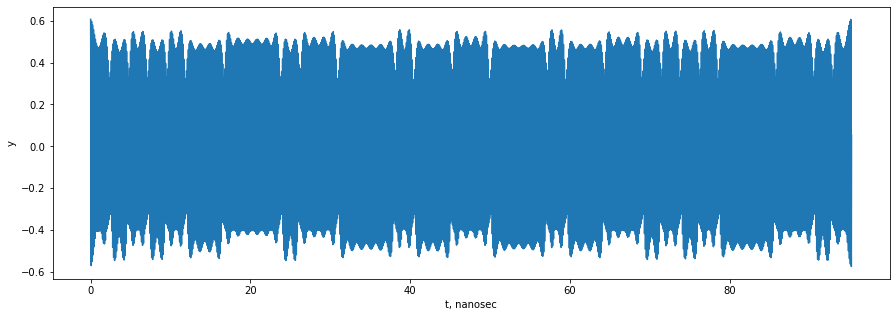

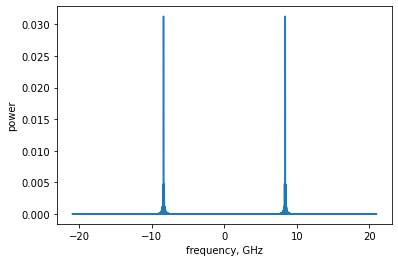

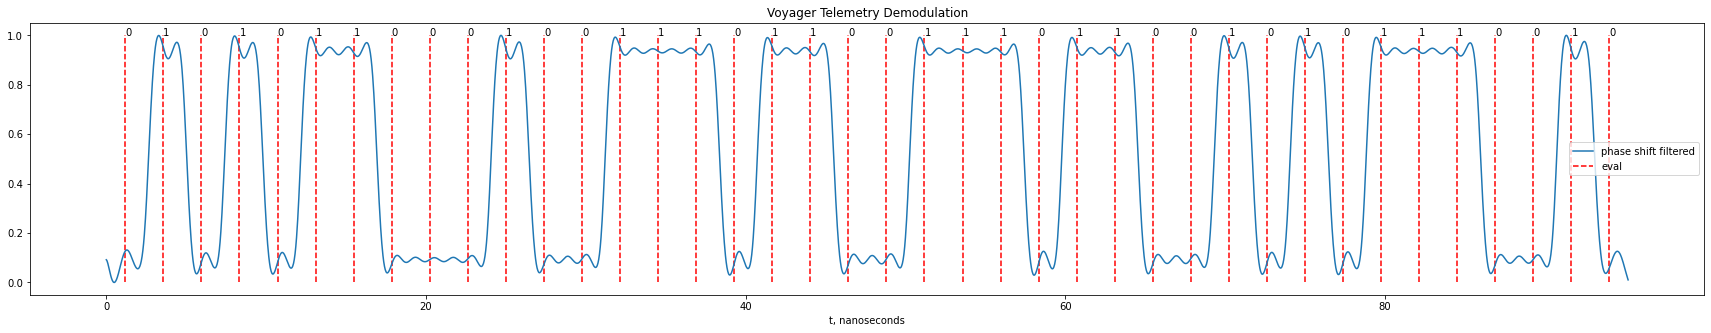

In [5]:
# NOTE: you must set the path to your data file here
data = np.loadtxt('data/voyager_signal.csv', delimiter=',')

t = data[:, 0]
f = data[:, 1]
nu = len(t)
dt = np.mean(np.diff(t))

plt.figure(figsize=(15, 5))
plt.plot(t*1e9, f)
plt.xlabel('t, nanosec')
plt.ylabel('y')

plt.figure()
ak = np.fft.ifft(f)
power = np.abs(ak)**2
freq = fft_freq = np.fft.fftfreq(len(data), dt)
plt.plot(freq*1e-9, power)
plt.xlabel('frequency, GHz')
plt.ylabel('power')

plt.figure(figsize=(30, 5))
plt.title('Voyager Telemetry Demodulation')
msg = decode_msg(t=t, f=f, freq_carrier=8.4e9, samples_per_period=100, plot=True)

if not os.path.exists('./fig'):
    os.mkdir('./fig')
plt.savefig('fig/voyager_decode.png')
print('my message was: "{:s}"'.format(msg))

# Demodulating Data with Noise

my message was: "\xff\xff\xf6\xbc\x88\x00R 7\xff\xff"


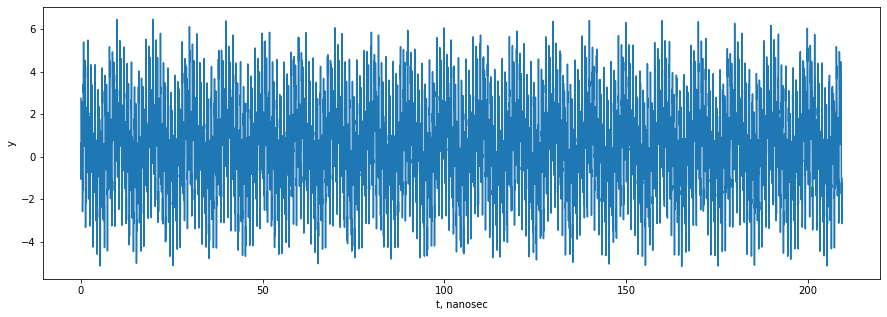

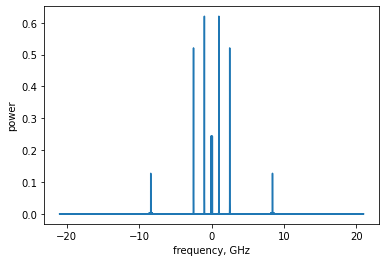

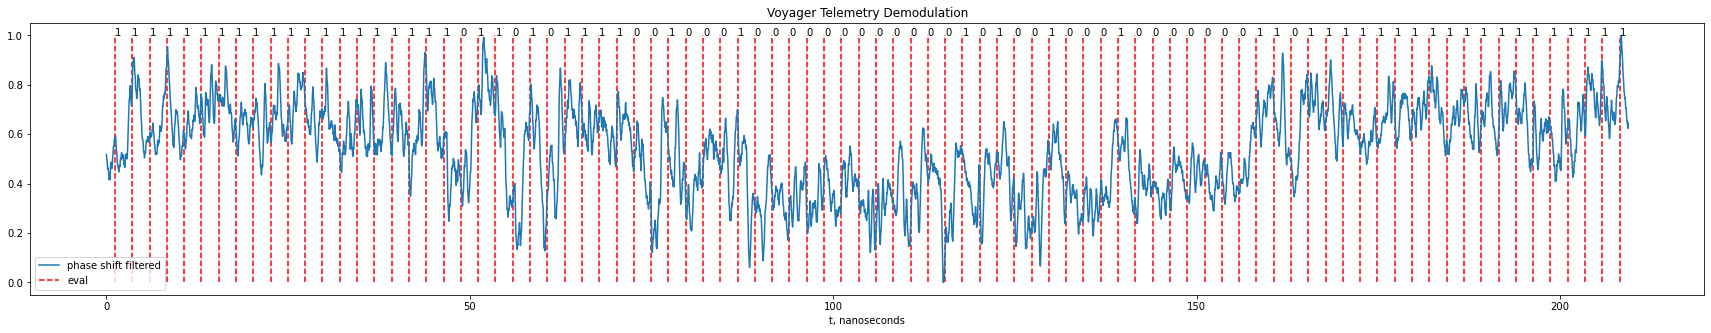

In [6]:
# NOTE: you must set the path to your data file here
data2 = np.loadtxt('data/id_000_problem_3.csv', delimiter=',')
t = data2[:, 0]
f = data2[:, 1]
nu = len(t)
dt = np.mean(np.diff(t))
plt.figure(figsize=(15, 5))
plt.plot(t*1e9, f)
plt.xlabel('t, nanosec')
plt.ylabel('y')

plt.figure()
ak = np.fft.ifft(f)
power = np.abs(ak)**2
freq = fft_freq = np.fft.fftfreq(len(data2), dt)
plt.plot(freq*1e-9, power)
plt.xlabel('frequency, GHz')
plt.ylabel('power')

plt.figure(figsize=(30, 5))
plt.title('Voyager Telemetry Demodulation')
msg = decode_msg(t=t, f=f, freq_carrier=8.4e9, samples_per_period=100, plot=True)

if not os.path.exists('./fig'):
    os.mkdir('./fig')
plt.savefig('fig/voyager_decode.png')
print('my message was: "{:s}"'.format(msg))

## Ideal Filter

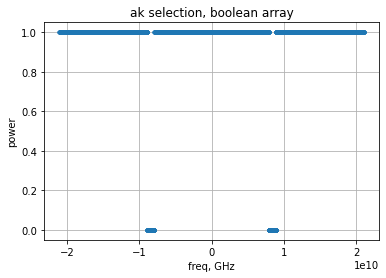

In [7]:
f_carrier = 8.4e9
side_band = 0.5e9
ak_select = abs(abs(freq) - f_carrier) > side_band
plt.plot(freq, ak_select , '.')
plt.xlabel('freq, GHz')
plt.ylabel('power')
plt.title('ak selection, boolean array');
plt.grid()

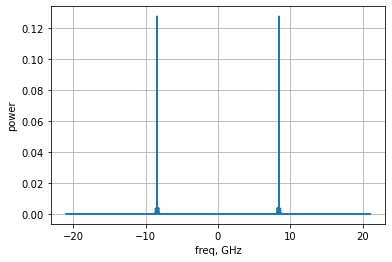

In [8]:
ak = np.fft.ifft(f)
ak[ak_select] = 0
power = abs(ak)**2
dt = np.mean(np.diff(t))
freq = np.fft.fftfreq(nu, dt)  # Hz
plt.plot(freq*1e-9, power)
plt.xlabel('freq, GHz')
plt.ylabel('power')
plt.grid()

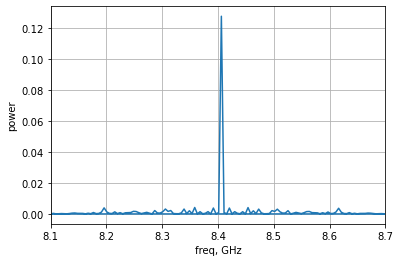

In [9]:
ak = np.fft.ifft(f)
ak[ak_select] = 0
power = abs(ak)**2
dt = np.mean(np.diff(t))
freq = np.fft.fftfreq(nu, dt)  # Hz
plt.plot(freq*1e-9, power)
plt.xlabel('freq, GHz')
plt.ylabel('power')
plt.gca().set_xlim([8.1, 8.7])
plt.grid()

Here we find the exact frequency of the carrier wave.

In [10]:
freq_carrier = freq[np.argmax(power)]
print('carrier frequency', freq_carrier*1e-9, 'GHz')

carrier frequency 8.406080000000001 GHz


'VOYAGER 798'

<Figure size 432x288 with 0 Axes>

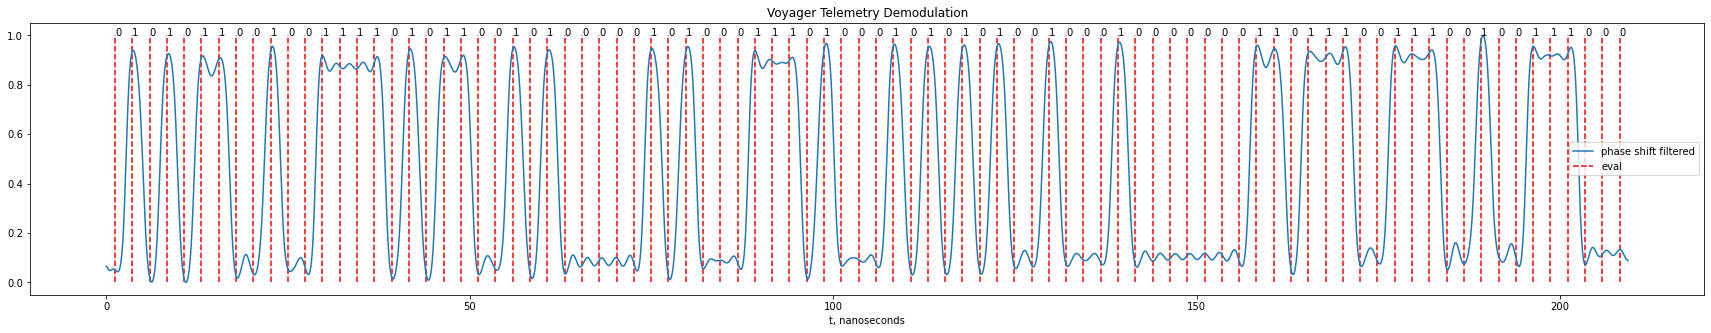

In [11]:
data_clean = np.real(np.fft.fft(ak))
plt.figure()

plt.figure(figsize=(30, 5))
plt.title('Voyager Telemetry Demodulation')
freq_carrier = freq[np.argmax(power)]
f_carrier_offset = 6000000  # necessary to fine tune carrier frequency manually due to fragility of decode script, want horizontal wave
msg = decode_msg(t=t, f=data_clean, freq_carrier=f_carrier + f_carrier_offset, samples_per_period=100, plot=True)
msg